A tutorial on applying Frank-Wolfe for sparse recovery of measures. 

Please refer to the following publications for futher details.

[1] Bredies, Kristian, and Hanna Katriina Pikkarainen. "Inverse problems in spaces of measures." ESAIM: Control, Optimisation and Calculus of Variations 19, no. 1 (2013): 190-218.

[2] Boyd, Nicholas, Geoffrey Schiebinger, and Benjamin Recht. "The alternating descent conditional gradient method for sparse inverse problems." SIAM Journal on Optimization 27, no. 2 (2017): 616-639.

[3] Denoyelle, Quentin, Emmanuel Soubies, Vincent Duval, and Gabriel Peyré. "Sparse Super-Resolution from Laplace Measurements."

In particular, this tutorial implements the sliding Frank-Wolfe algorithm detailed in [3].
We consider the case of recovery a sparse measure $\mu = \sum_j a_j \delta_{x_j}$ on the Torus and $\Phi$ is a Fourier operator $\Phi\mu = \int \phi(x)\mathrm{d}\mu(x)$ where $\phi(x) =  \left(e^{2\pi i k x} \right)_{k\in \Gamma}\in \mathbb{C}^{|\Gamma|}$, $\Gamma = \{ -f_c, \ldots, f_c\}$. 

We will discuss how to solve the BLASSO.
$$
\min_\mu \frac{1}{2} \| \Phi \mu - y\|_2^2 + \lambda |\mu|(\mathbb{T}).
$$
In this document, given $X = \{x_j\}_j$, we define $\Phi_X a := \sum_j a_j \phi(x_j)$.


In [1]:
addpath('toolbox/');
addpath('lbfgsb/');

lambda = 0.05; %regularisation parameter


Define the sampling operator:

In [2]:
fc = 10;
freq = (-fc:fc)';
% freq = randi(fc,15,1)-fc;

vrt = @(x) x(:);
Phi =@(x) exp(2*pi*1i*vrt(freq)*vrt(x).')/sqrt(2*fc+1);
dPhi =@(x) diag(2*pi*1i*freq)*exp(2*pi*1i*vrt(freq)*vrt(x).')/sqrt(2*fc+1);

Define the kernel $C(x,x') = \langle \phi(x), \phi(x')\rangle$.

In [3]:
%C = Phi_U'*(Phi_X*a) is a vector of size U
C = @(U,X) (Phi(U))'*Phi(X);
%dC = (Phi_U)^{(1)}'*(Phi_X*a) is a vector of size U
dC = @(U,X) (dPhi(U))'*Phi(X);


Define the true positions $X_{true}$ and amplitudes $a_{true}$:

In [4]:
a_true = [2 2 3 -5]'; %true amplitudes
X_true = [0.1, 0.13, 0.6, 0.67]; %true positions



Add noise of the form $w = \Phi(\sum_{j=1}^{20} b_j \delta_{z_j})$ where $z_j$ are randomly chosen points, then display the observation $y = \Phi^*(\Phi \mu_{a_{true},X_{true}}+w)$.

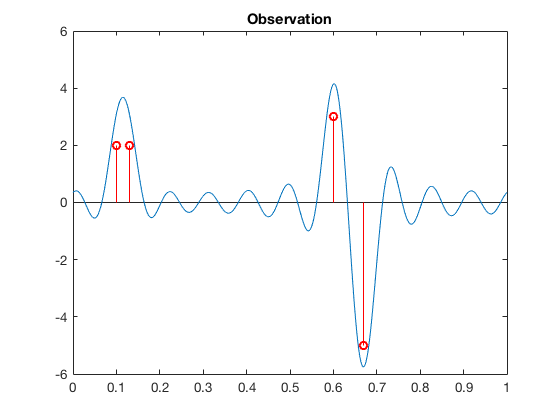

In [6]:
%add noise
Xn = rand(1,20);
an = 1e-2*(rand(1,20)-0.5)';

a0 = [a_true;an];
X0 = [X_true,Xn];

Energy = @(x,a)1/2*norm(Phi(x)*a-Phi(X0)*a0)^2 +lambda* norm(a,1); %energy we want to minimise

u = linspace(0,1,2000); %parameter search space
figure(10);
clf;
obs = C(u,X0)*a0;
plot(u,real(obs));
hold on
stem(X_true,a_true, 'r');
title('Observation')


Plot the vanishing derivatives precertificate.
$$
\eta_V(x) = \sum_j u_j C(x_j,x) + \sum_j v_j \partial_1 C(x_j,x), \qquad \binom{u}{v} = M^{-1} \binom{\mathrm{sign}(a)}{0_s}
$$
with
$$
M = \begin{pmatrix}
M_0 & M_1\\
M_1^* & M_2
\end{pmatrix}, \quad M_0 = (C(x_j,x_k))_{j,k}, \quad M_1 = (\partial_1C(x_j,x_k))_{j,k}, \quad M_2 = (\partial_1\partial_2C(x_j,x_k))_{j,k}
$$

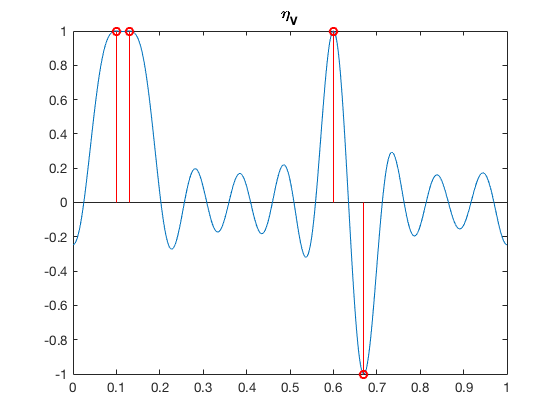

In [8]:
%% vanishing derivatives certificate
S = [sign(a_true); zeros(length(a_true),1)];
ddC = @(U,X) (dPhi(U))'*dPhi(X);
Cd = @(U,X) (Phi(U))'*dPhi(X);

M = [C(X_true,X_true), Cd(X_true,X_true); ...
    (Cd(X_true,X_true))', ddC(X_true,X_true)];
coeffs = (M\S);
etaV = [C(u,X_true), Cd(u,X_true)]*coeffs;

%display
figure(11); clf
plot(u,real(etaV));
hold on
stem(X_true, sign(a_true), 'r');
title('\eta_V')

A naive approach for solving the BLASSO would be to discretize on a fine grid $u$, and solve
$$
\min_a \lambda |a|_1 + \frac{1}{2} |\Phi_u a - y|_2
$$
where $\Phi_u a = \sum_j a_j \phi(u_j)$. We can then apply iterative soft-thresholding (ISTA) to solve this, by
$$
a^{k+1} = Soft_{\lambda\gamma}(a^k - \gamma \Phi_u^* (y - \Phi_u a^k))
$$

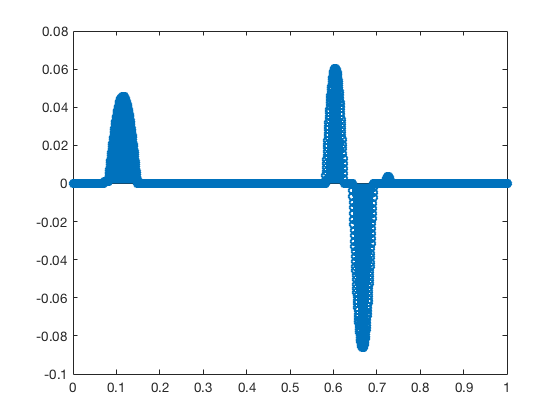

In [61]:
%% perform ISTA
%solve min_a lambda* |a|_1 + 1/2 * |Phi_u * a - Phi_u * a0 |_2
  
%     gamma = 1/norm(C(u,u)); %stepsize
    maxit = 100;   
%     ai = zeros(size(u)).';
    for it=1:maxit
        ai = ai +gamma* (C(u,X0)*a0 -C(u,u)*ai);
        ai = wthresh(ai,'s',gamma*lambda);        
    end
stem(u,real(ai));

The Frank-Wolfe algorithm, applied to the BLASSO, works iteratively alternates between a `matching pursuit' step where a new support point is added, and a local improvement step where the positions and amplitudes are optimised locally. 


In [9]:
a = [];
X = [];

Given positions $a^k$ and $X^k$, the matching pursuit step works as follows: define
$$
\eta_k(x) = \frac{1}{\lambda}(\Phi^* y- \Phi^* \Phi_{X^k}a^k).
$$
If $|\eta_k|_\infty \leq 1$, then the optimality condition is satisfied and we can terminate. Otherwise, add a new point $x_{new}$ and a new amplitude $a_{new}$, where
$$
x_{new} = \mathrm{argmax}_{x\in \mathbb{T}} |\eta_k(x)|, \qquad a_{new} = \eta^k(x_{new}).
$$

In [10]:
if ~isempty(a)
    etak = (C(u,X0)*a0 - C(u,X)*a)/lambda;
else
    etak = C(u,X0)*a0/lambda;
end

%add new spike, I simply search for largest abs value on grid here, but
    %you could add a local ascent step
[v,pos] = max(abs(etak));
xnew = u(pos);

a = [a; etak(pos)];
X = [X,xnew];

% stem(X,real(a));
disp(X)
disp((real(a(:)')))
disp(Energy(X,a))

    0.6693

 -114.9708

   5.9808e+03



Now, with the augmented amplitudes $a$ and positions $X$, we now locally improve upon the amplitudes by solving
$$
\min_a \lambda |a|_1 + |\Phi_X a - y|_2^2
$$
using ISTA:

In [11]:
ista_maxit = 300;
ai = a;
gamma = 1/norm(C(X,X));
for it=1:ista_maxit
    ai = ai +gamma* (C(X,X0)*a0 -C(X,X)*ai);
    ai = wthresh(ai,'s',gamma*lambda);
end
a = ai;
% stem(X,real(a));
disp(X)
disp(a)
disp(Energy(X,a))

    0.6693

  -5.6985 + 0.0000i

   10.5476



Finally, locally improve upon the amplitudes and positions simultaneuously by solving 
$$
\min_{a,X} \lambda |a|_1 + |\Phi_X a - y|_2^2
$$
using LBFGS. Note that this is a nonconvex problem, but in the case where $\eta_V$ is nondegenerate, finite terminations is guaranteed even if we only compute a stationary point:

In [12]:
op.nablaEx = @(x,a,x0,a0,lambda) diag(a) * ( dC(x,x)*a- dC(x,x0)*a0);
op.nablaEa = @(x,a,x0,a0,lambda) ( C(x,x)*a- C(x,x0)*a0 ) +lambda* sign(a);
op.E = @(x,a,x0,a0,lambda)1/2*norm(Phi(x)*a-Phi(x0)*a0)^2 +lambda* norm(a,1);
options.verb = 0;
[X,a,R] = noncvx_sparse_spikes(op,lambda, X0,a0, X,a, options);
X = X(:).';        

% stem(X,real(a));
disp(X)
disp(a)
disp(Energy(X,a))

    0.6692

  -5.6986 + 0.0000i

   10.5470



So, putting everything together, we have the following (with termination condition $|\eta_k|_\infty \leq 1$)


k =

     5



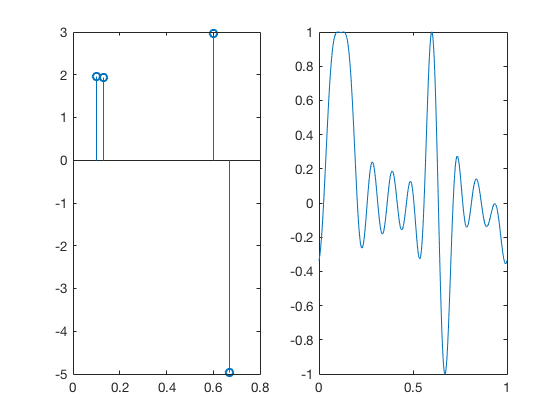

In [14]:
do_noncvx = 1; %include nonconvex update?
%inputs for LBFGS
% E(x,a) = 1/2*|Phi(x)*a - y|^2 + lambda* |a|_1
%   nabla_a E(x,a) =  Phi(x)' * (Phi(x)*a-y) + lambda
%                  = [ C(x,x)*a-C(x,x0)*a0 ] + lambda
%   nabla_x E(x,a) =  diag(a)*Phi'(x)' * (Phi(x)*a-y)
%                  =  a .* [ CD(x,x)*a-CD(x,x0)*a0 ]
op.nablaEx = @(x,a,x0,a0,lambda) diag(a) * ( dC(x,x)*a- dC(x,x0)*a0);
op.nablaEa = @(x,a,x0,a0,lambda) ( C(x,x)*a- C(x,x0)*a0 ) +lambda* sign(a);
op.E = @(x,a,x0,a0,lambda)1/2*norm(Phi(x)*a-Phi(x0)*a0)^2 +lambda* norm(a,1);


maxit = 150; %max number of Frank-Wolfe iterations
ista_maxit = 300; %max number of interal ISTA iterations
a = [];
X = [];

figure(21); clf
for k=1:maxit
       
    if ~isempty(a)
        etak = (C(u,X0)*a0 - C(u,X)*a)/lambda;
    else
        etak = C(u,X0)*a0/lambda;
    end
        
    %display
    subplot(1,2,1)
    stem(X,real(a));
    subplot(1,2,2)
    plot(u,real(etak));
    drawnow
       
    %add new spike, I simply search for largest abs value on grid here, but
    %you could add a local ascent step
    [v,pos] = max(abs(etak));
    xnew = u(pos);
    if v<1+1e-5
        break
    end
    a = [a; etak(pos)];
    X = [X,xnew];
        
    %perform ISTA to optimise amplitudes
    ai = a;
    gamma = 1/norm(C(X,X));
    for it=1:ista_maxit
        ai = ai +gamma* (C(X,X0)*a0 -C(X,X)*ai);
        ai = wthresh(ai,'s',gamma*lambda);
    end
    a = ai;
       
    %simulaneously optimise amplitudes and pos.
    options.verb = 0;
    if do_noncvx
        [X,a,R] = noncvx_sparse_spikes(op,lambda, X0,a0, X,a, options);
        X = X(:).';        
    end   
    
end
k